<font size="7"> <b>Welcome</b> </font>

<font size="4"> This is Abdessalem Boukil, and this is a full EDA on a dataset of the attendance of a gym, and my suggestions for a better schedule.</font>
<font size="4"> I kept the code so my work is reproducible. </font>

In [1]:
import pandas as pd 
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import matplotlib


xls = pd.ExcelFile('dataset.xlsx')
collection = pd.read_excel(xls, 'Attendance from collection')
live = pd.read_excel(xls, 'Live attandence')
schedule = pd.read_excel(xls, 'Class schedule')

live["event_id_of_live_class"] = live["live_class_id"].apply(lambda x: int(x[2:]))
live["live"] = True
collection["live"] = False

cols = ["class_name", "training_date", "instructor_name", "event_id_of_live_class", "live"]
concatted = pd.concat((live.rename(columns={"live_class_name": "class_name"})[cols], collection[cols])).sort_values(by="training_date")

## I. Which classes are the most and least popular?

<font size="3"><b>Answer:</b> The most popular class is <i>V/Pilates: Intro für Einsteiger</i> with 147 attendees in total. On the other hand, the least popular class is <i>V/Shred: Cardio vs. Strength Bootcamp</i> with only 4. To reach this answer, I concatenated the live spreadsheet, and the attendance from collection spreadsheet, then calculated the frequency of every class, only to sorted them later.</font>

### Most popular

In [2]:
concatted.groupby("class_name").size().sort_values().tail(5)

class_name
V/Box: Full-Body Punches & Kicks      97
V/Build: Ganzkörper-Krafttraining    108
V/Build: Sixpack                     113
V/Sweat: High Energy Cardio          124
V/Pilates: Intro für Einsteiger      147
dtype: int64

### Least popular

In [3]:
concatted.groupby("class_name").size().sort_values().head(5)

class_name
V/Shred: Cardio vs. Strength Bootcamp    4
V/Burn: AMRAP HIIT                       5
V/Stretch: Morning Mobility              5
V/Flow: Morning-Yoga                     7
V/Sweat: Fatburn Cardio                  8
dtype: int64

## II. How would you adjust the class schedule to increase the attendance rate of the live classes?

<font size="3">During the analysis I made on the data, I noticed many aspects to be adjusted in the schedule. I am going to get to each one of them point by point, with the help of data visualization.</font>

---------

<font size="3"><b>Observation:</b> Live classes at 5, 6 and 7 am barely have low attendance rate, however they are very frequent. On the other hand, classes after 8 are less frequent, yet on average, they have higher attendance rate. This can be seen easily from this bar chart.</font>

In [4]:
live["Hours"] = live.training_started_at.dt.hour
viz_data = pd.DataFrame(live.drop_duplicates("live_class_id").groupby("Hours").size(), columns=["Number of classes"])

attendance = pd.DataFrame(live.groupby("Hours").size(), columns=["Attendance"])
viz_data = viz_data.join(attendance).reset_index()

viz_data["Attendees/Class"] = viz_data["Attendance"] / viz_data["Number of classes"]

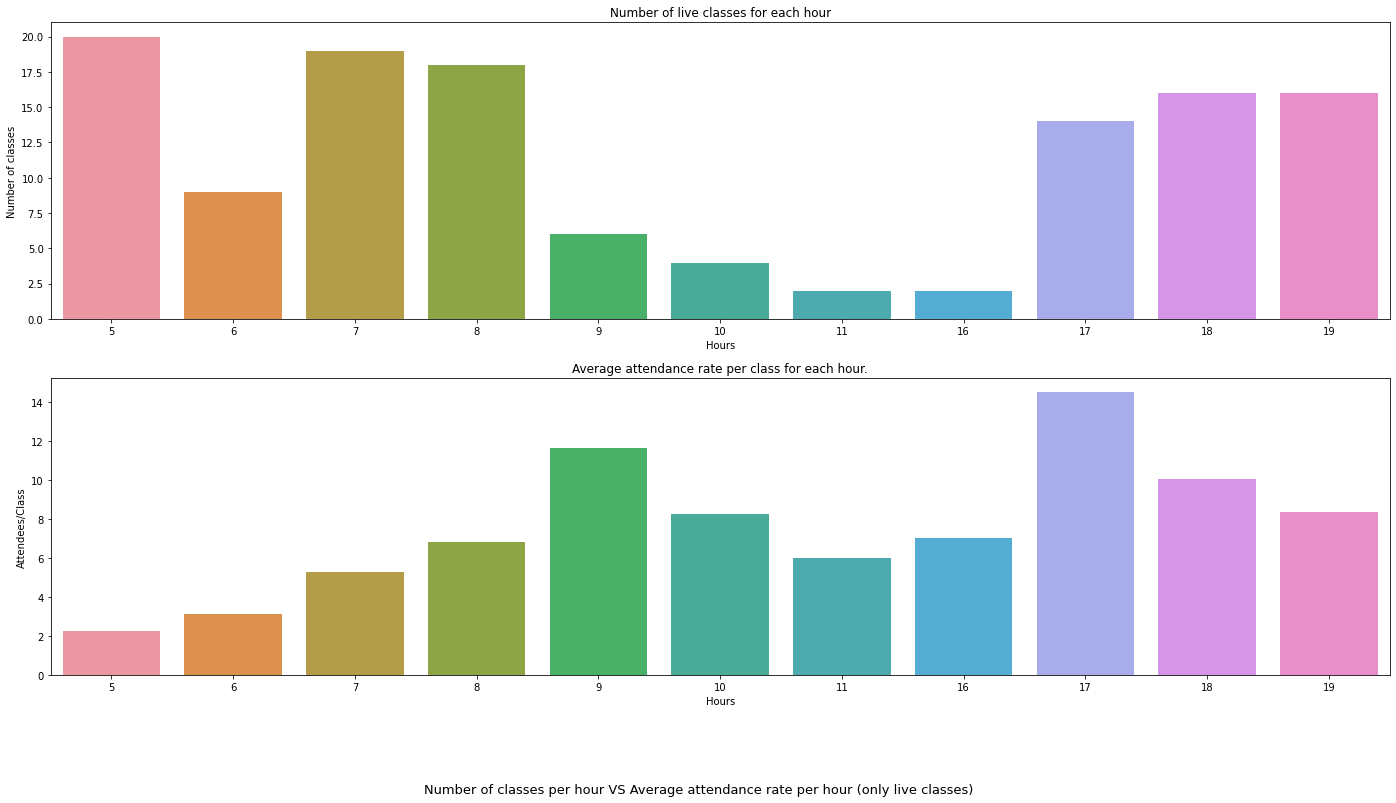

In [5]:
#Add another plot on the right side showing the attendance normalized

f, axes = plt.subplots(2, 1, figsize=(24,12))

g = sns.barplot(x="Hours", y="Number of classes", data=viz_data, ax=axes[0]).set(title="Number of live classes for each hour")
g = sns.barplot(x="Hours", y="Attendees/Class", data=viz_data, ax=axes[1]).set(title='Average attendance rate per class for each hour.')

g = f.suptitle("Number of classes per hour VS Average attendance rate per hour (only live classes)", y=0, fontsize="13")

<font size="3">Looking at the plot on top, it's easy to see that the 5, 7 and 8 am classes are the most frequent, however on the bottom plot, we notice that these very same classes have the lowest attendance rate on average. We also note that classes at 9, 10 and 11 am are less in frequency but have higher attendance rate.</font>

<font size="3"><b>Solution:</b> Increase the frequency of classes al 9, 10 and 11am, and decrease the frequency of classes at 5, and 7am; or maybe merge them into one daily class 6:30.</font>

----------
<font size="3"><b>Observation:</b> There is no live classes in the afternoon (11am -> 4pm), but we see from the attendance from collection spreadsheet that a considerable number of people attend classes in that time. Limiting classes to only morning or evening also limits the attendance rate of live classes.</font>

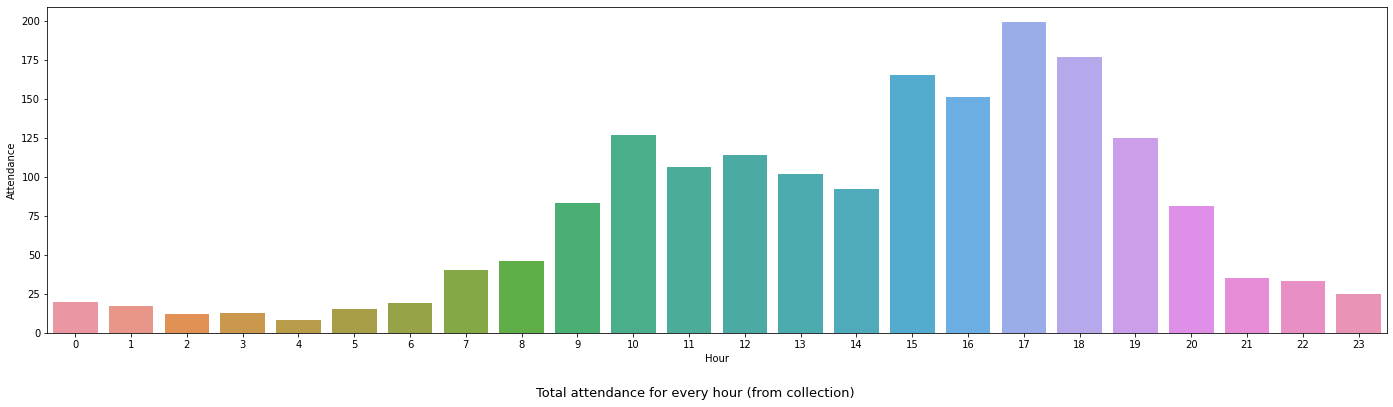

In [6]:
collection["Hour"] = collection.training_started_at.dt.hour

viz_data = pd.DataFrame(collection.groupby("Hour").size(), columns=["Attendance"]).reset_index()
plt.figure(figsize=(24, 6))

g = sns.barplot(x="Hour", y="Attendance", data=viz_data)
g = plt.suptitle("Total attendance for every hour (from collection)", y=0, fontsize="13")

<font size="3">As we see in the plot, a considerable number of people attend in the hours 12, 13, 14, 15 (473 in total). These people could be attending live class if there was any live class at that time range.</font>

<font size="3"><b>Solution:</b> Limit live classes in early morning and add classes in the afternoon.</font>

-----

<font size="3"><b>Observation:</b> Some classes tend to attract more people live, and some other classes tend to me attended from the collection rather in live. Same goes for certain training categories. We can see the correlation between the attendance rate, and wether the class is live or from the collection.</font>

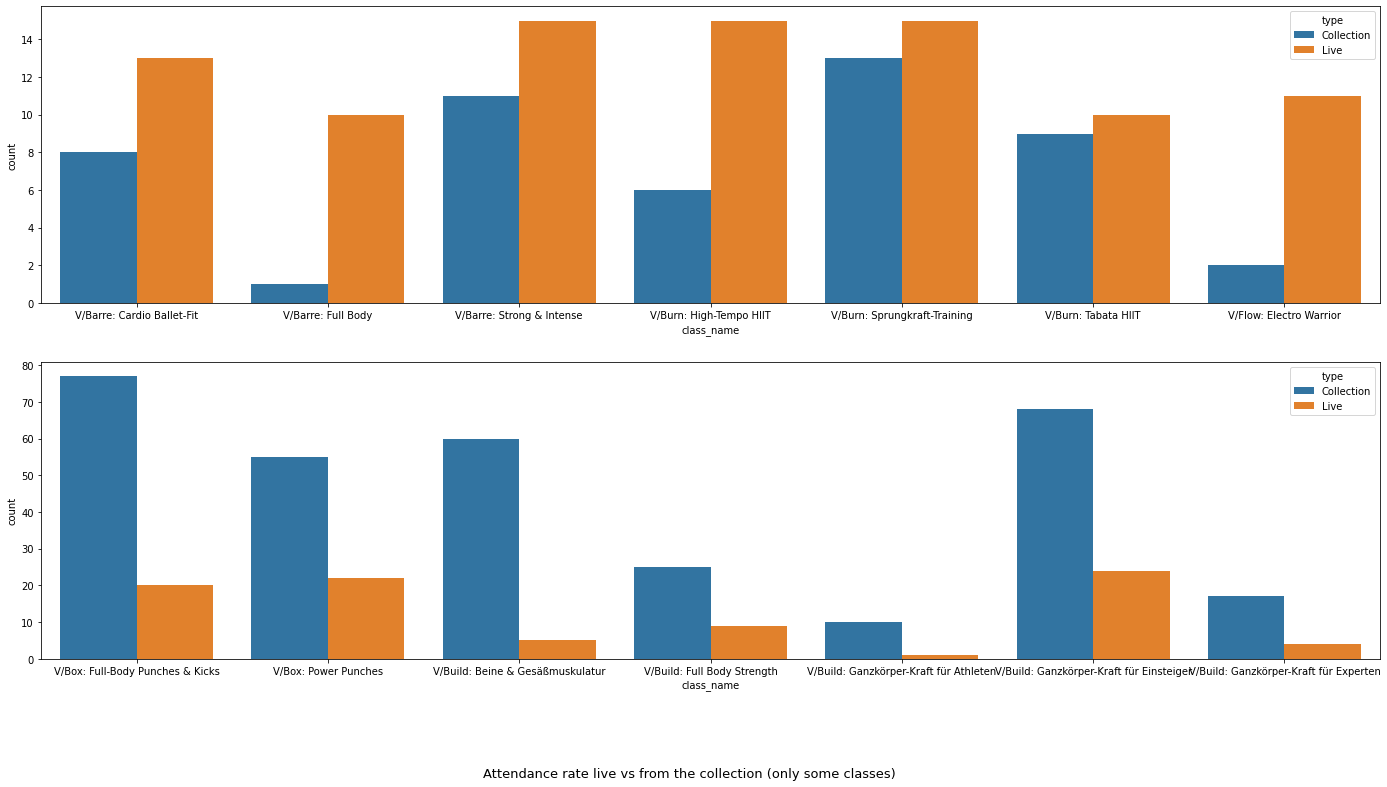

In [7]:
f, axes = plt.subplots(2, 1, figsize=(24,12))


tmp_live = live[~live.live_class_name.isin(set(live.live_class_name) ^ set(collection.class_name))] #Remove non overlapping classes

class_count_collection = pd.DataFrame(collection.groupby("class_name").size(), columns=["count"]).reset_index()
class_count_live = pd.DataFrame(tmp_live.groupby("live_class_name").size(), columns=["count"]).reset_index()

class_count_collection["type"] = "Collection"
class_count_live["type"] = "Live"
class_count_live.columns = ["class_name", "count","type"]


mask1 = class_count_collection["count"] < class_count_live["count"]
mask2 = class_count_collection["count"] > (class_count_live["count"]*2)


g = sns.barplot(x="class_name", hue="type", y="count", data=pd.concat((class_count_collection[mask1].iloc[:7], class_count_live[mask1].iloc[:7]), axis=0), ax=axes[0])
g = sns.barplot(x="class_name", hue="type", y="count", data=pd.concat((class_count_collection[mask2].iloc[:7], class_count_live[mask2].iloc[:7]), axis=0), ax=axes[1])

g = f.suptitle("Attendance rate live vs from the collection (only some classes)", y=0, fontsize="13")

<font size="3"> As we see, classes like <i>V/Barre: Full Body</i> and <i>V/Flow: Electro Warrior</i> attract more people live than people watching the recorded class. These classes represent 31% of all classes. That said, there are other classes that people only watch recorded rather than attending them live (e.g. <i>V/Build: Beine & Gesäßmuskulatur</i> and <i>V/Box: Full-Body Punches & Kicks</i>). This can easily be seen in the bottom plot. </font>

<font size="3"> Same can be said for training categories, some attract more people live than others, this can be seen in the plot below.</font>

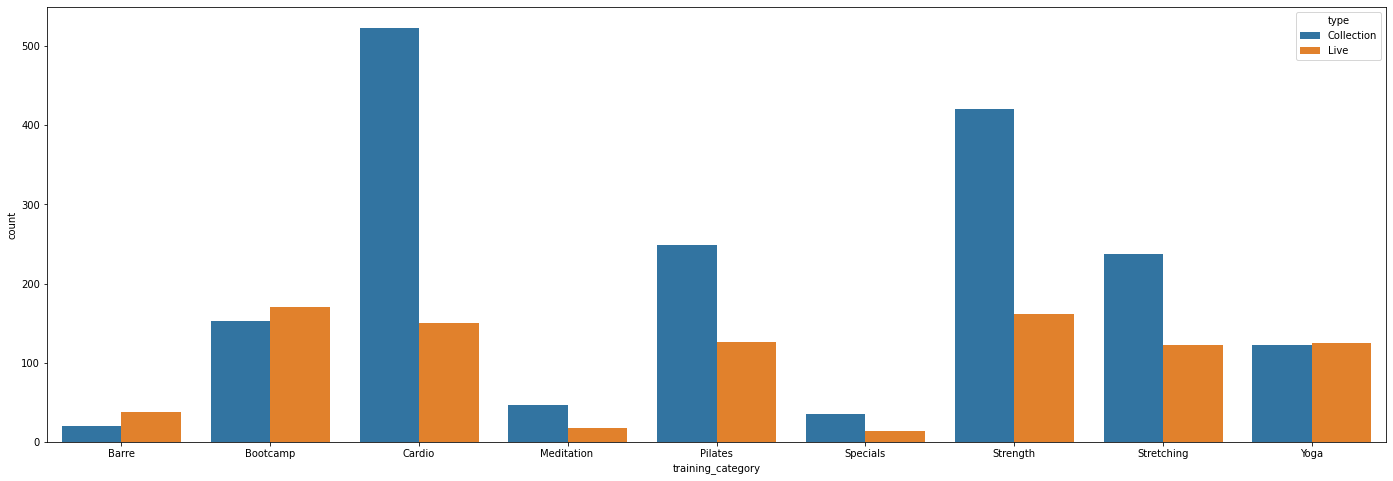

In [8]:
class_count_collection = pd.DataFrame(collection.groupby("training_category").size(), columns=["count"]).reset_index()
class_count_live = pd.DataFrame(live.groupby("training_category").size(), columns=["count"]).reset_index()

class_count_collection["type"] = "Collection"
class_count_live["type"] = "Live"
class_count_live.columns = ["training_category", "count","type"]

joined = pd.concat((class_count_collection, class_count_live), axis=0)

plt.figure(figsize=(24, 8))

sns_plot = sns.barplot(x="training_category", hue="type", y="count", data=joined)


<font size="3"> Training categories such as *Bootcamps*, *Barre*, and *Yoga* attract more people live. And some other training types are watched recorded way more than life, like *Cardio* for example.

<font size="3"> <b>Solution:</b> Since people are more apt to attend certain classes live rather than record, add more of these classes that attract more people live (<i>V/Barre: Full Body, V/Barre: Cardio Ballet-Fit, V/Burn: High-Tempo HIIT ...</i>) and classes belonging to the following training categories: <i>Bootcamp, Yoga, Barre</i> in the schedule. This would probably increase attendance in live classes. Limit the number of classes from the training category <i>Cardio</i> and <i>Strength</i> in the schedule. Also limit classes that barely have any live attendance.</font>

------

#### Conclusion:

1. <font size="3">Limit live classes in early morning and add classes in the afternoon.</font>
2. <font size="3">Increase the frequency of classes al 9, 10 and 11am, and decrease the frequency of classes at 5, and 7am; or maybe merge them into one daily class 6:30.</font>
3. <font size="3">More of the classes that attract more people live in the schedule, and limit classes that are watched recorded more than live. More classes belonging to the following training categories: <i>Bootcamp, Yoga, Barre</i> and limit classes from these categories: <i>Cardio, Strength</i>.

## III. What addtitional improvements can you suggest to the class experience and what additional data points would you need for that?

<font size="3">1. Some classes, on average, are barely completed. This can explained to the nature of class, or the level of difficulty. To remedy this, and to improve the experience of clients I suggest I suggest the duration of classes that are on average, only 75% or less completed. Classes like: </font>

In [9]:
common = ["class_name", "class_completed_pct","rating_intensity", "member_id"]
rename = {"live_class_name": "class_name", "live_class_completed_pct": "class_completed_pct"}

concatted = pd.concat((collection[common], live.rename(columns=rename)[common] ))
stats = concatted.groupby(["class_name"])["class_completed_pct"].agg(["mean","count"]).sort_values(by="mean")
stats["mean"] = (stats["mean"]*100).apply(lambda x: str(x)[:5] + "%")
stats.columns = ["Percentage Completion", "Number of attendance"]
stats[stats["Number of attendance"] > 80].head()

,Percentage Completion,Number of attendance
class_name,,
V/Box: Full-Body Punches & Kicks,36.56%,97
V/Sweat: High Energy Cardio,40.86%,124
V/Build: Ganzkörper-Krafttraining,49.62%,108
V/Flow: Vinyasa-Yoga für Einsteiger,53.66%,81
V/Build: Ganzkörper-Kraft für Einsteiger,65.19%,92


<font size="3">2. I suggest an alternate grouping of the classes based on tags. These clustered classes can be used to create a schedule with every day containing classes clustered together. This may add a sense of consistency for clients, so they can expect what muscles they would be activating at each day.<font>

In [10]:
#Clusering the classes using Kmeans algorithm
collection["tags_ids"] = collection["tags_ids"].apply(lambda x: " ".join([str(i) for i in list(ast.literal_eval(x))]) )

N_categories = 9

tmp = collection.drop_duplicates("class_name")
tmp = tmp.assign(tags=tmp['tags_ids'].str.split()).explode('tags')
tmp = tmp[['class_name', 'tags']]
tmp = pd.get_dummies(tmp, columns=['tags'])
tmp = tmp.groupby('class_name').agg(['sum'])

km = KMeans(n_clusters=N_categories,
            init='random',
            n_init=10,
            random_state=0)

X = tmp.iloc[:, 1:]
cluster_labels = km.fit_predict(X)


tmp['group'] = cluster_labels
tmp = tmp.reset_index()
tmp = tmp[['class_name', 'group']]
tmp.columns = tmp.columns.droplevel(1)

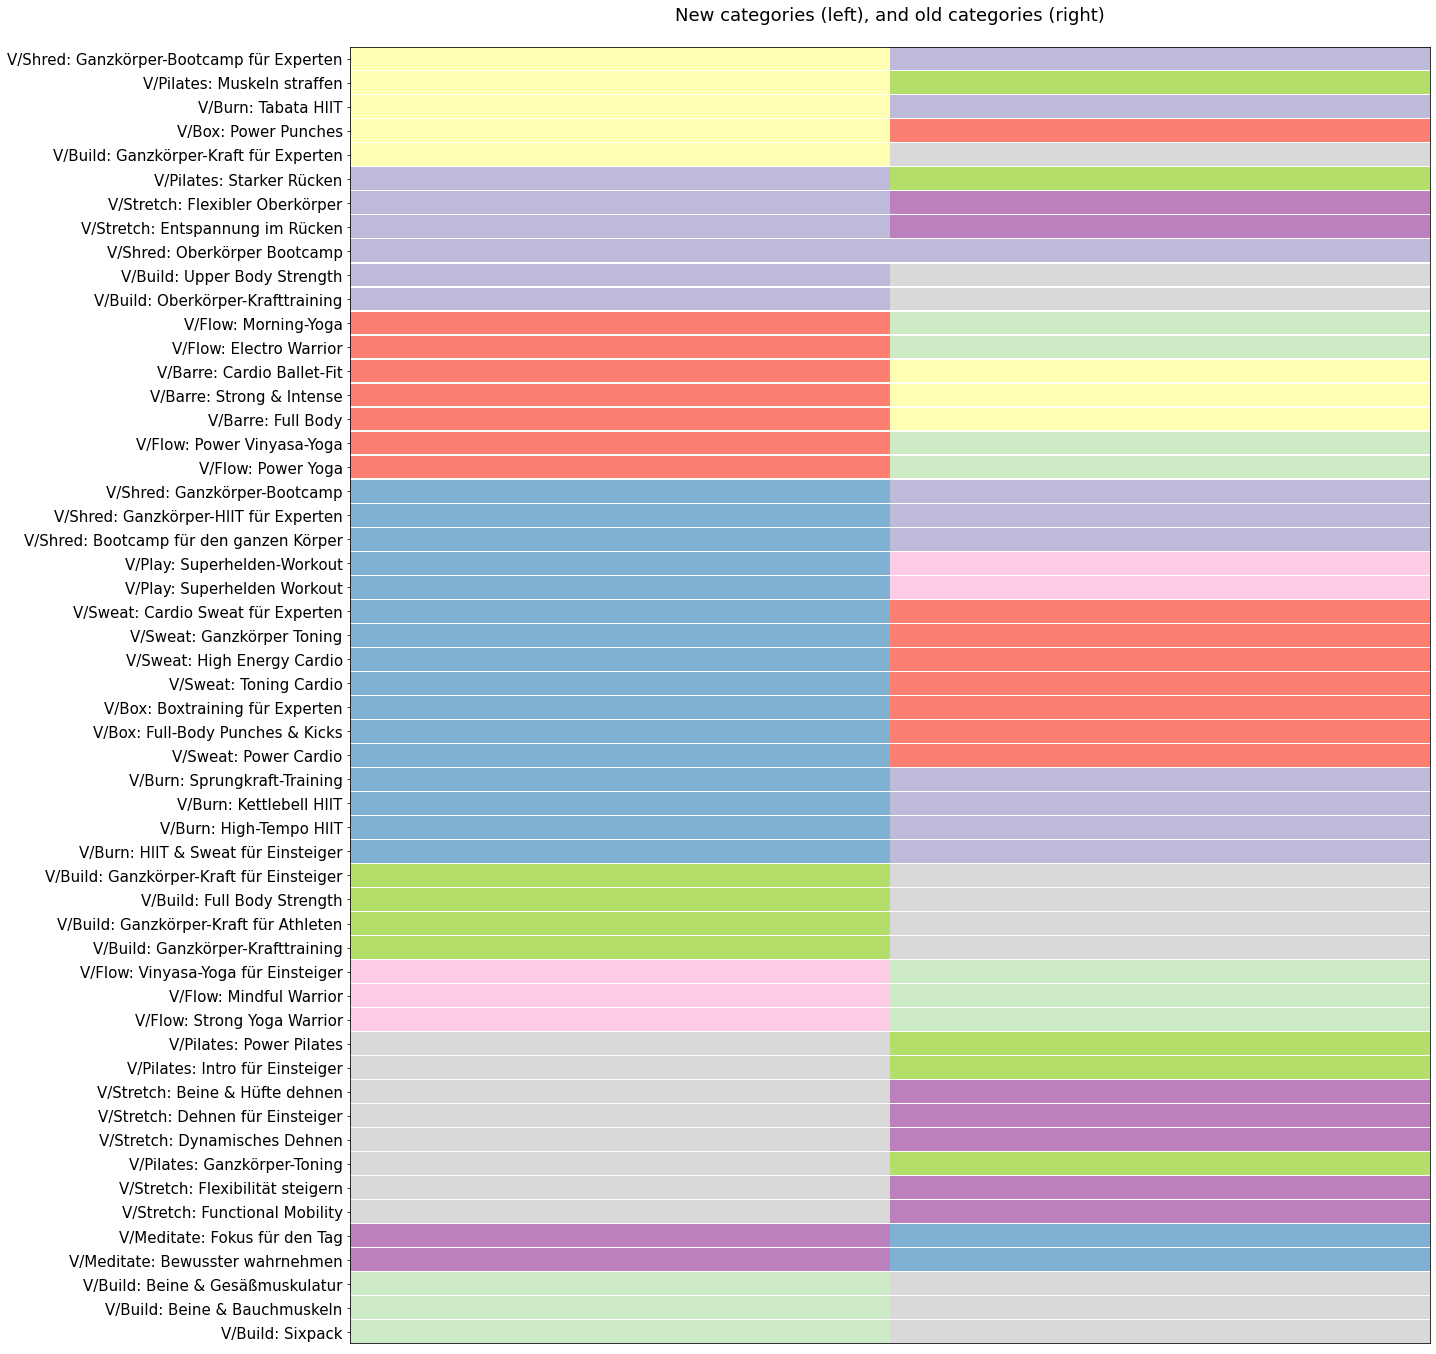

In [11]:
tmp = tmp.sort_values(by="group")

tmp = tmp.merge(collection.drop_duplicates("class_name").set_index("class_name")["training_category"], how="left", left_on="class_name", right_index=True)
tmp.training_category = tmp.training_category.astype('category').cat.codes


results = {}
categ_1 = []
categ_2 = []

for i, row in tmp.iterrows():
    results[row.class_name] = [50, 50]
    categ_1.append(row.group)
    categ_2.append(row.training_category)
    
arr = [categ_1, categ_2]

font = {'weight' : 'light',
        'size'   : 15}

matplotlib.rc('font', **font)

labels = list(results.keys())
data = np.array(list(results.values()))
data_cum = data.cumsum(axis=1)
category_colors = plt.get_cmap('Set3')(
    np.linspace(0.15, 0.85, max(tmp.training_category.unique().shape[0], N_categories)))

fig, ax = plt.subplots(figsize=(15, 18))
ax.invert_yaxis()
ax.xaxis.set_visible(False)
ax.set_xlim(0, np.sum(data, axis=1).max())

for i in range(2):

    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.95, color=category_colors[arr[i]])

plt.margins(y=0)    
    
plt.title("New categories (left), and old categories (right)\n")
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)

<font size="3"> The plot above shows a comparison between the old training categories, and the newly clustered training categories. Every color represents a distinct category. We can see that some of the new and old categories meet at some points, but mostly they are different. This new classification, since it is based on the tags, might be more intuitive for the users. Also it might be the base for a new schedule that partition every day's classes based on a specific category.

-----
<font size="3"> Another idea might be to segment the clients based on the classes they attend, their consistency, and whether they attend live classes or not. But to do this, I would need first, more data for both live attendance and attendance from collection, and second, the age, heigh, weight and gender of the client. This will help in creating a more customized experience for every user.
    
&nbsp;
&nbsp;
&nbsp;


&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;
&nbsp;

## Hope you like my work,
# <b>Best regards. </b>